In [1]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Herramienta para diseñar PSS

### Instrucciones:

Realizar una simulación en el tiempo donde a la máquina a la cual se le desea diseñar el PSS se le sube la tensión de referencia un 5% en forma de escalón. La simulación se debe guardar en el documento voltage_omega.dat con tres columnas: tiempos, tensión en terminales de la máquina ensayada y velocidad de la misma. Ejemplo:

```
 0.00000   1.00000   1.03000  
 0.02500   1.00000   1.03000  
 0.05750   1.00000   1.03000  
 0.09975   1.00000   1.03000  
 0.15468   1.00000   1.03000  
 0.22608   1.00000   1.03000  
 0.31890   1.00000   1.03000  
```

### Carga de datos y definición de parámetros 

In [3]:
data = np.genfromtxt('voltage_omega.dat')
T = data[:,0]
V = data[:,2]
W = data[:,1]
N = np.size(T)

# Tiempo de inicio del escalón:
t_ini = 1.0

# Constante de tiempo del washout:
T_wo = 10.0

# Frecuencia de las oscilaciones
freq = 0.36

### Ajuste de la respuesta de primer orden

In [4]:
def func_v(t, a, b, c, d):
    return c + a* np.exp(-b * t) + d*t

idt = np.argmax(T>t_ini)
popt_v, pcov = curve_fit(func_v, T[idt:], V[idt:])
V_ini = V[0]
V_end = V[-1]
DV = popt_v[2] - V_ini
tau = 1/popt_v[1]
Tau_avr = tau


In [5]:
print(f'Constante de tiempo equivalente del AVR tau = {tau:0.2f} s')
tau = 1.16

Constante de tiempo equivalente del AVR tau = 0.48 s


<IPython.core.display.Javascript object>


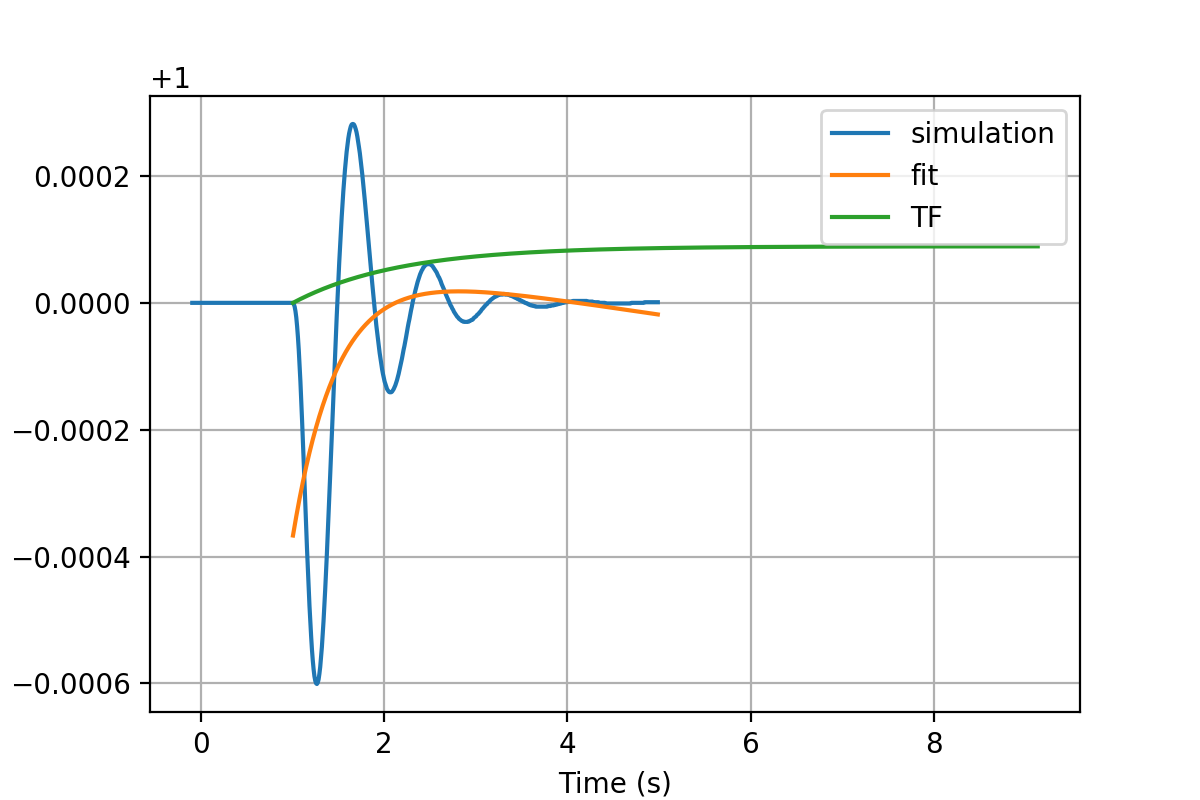

Text(0, 0.5, 'Voltage (pu)')

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex = True)

axes.plot(T,V, label='simulation')
a, b, c, d = popt_v
axes.plot(T[idt:],func_v(T[idt:], a, b, c, d),  label='fit')


num = [1]
den = [tau , 1]
G_avr = signal.TransferFunction(num, den)
T_avr,Y_avr = signal.step(G_avr, N=1000)
axes.plot(T_avr+T[idt],DV*Y_avr+V_ini,  label='TF')
axes.grid()
axes.legend()
axes.set_xlabel('Time (s)')
axes.set_ylabel('Voltage (pu)')

### AVR phase for given frequency

In [7]:
w_avr, mag_avr, phase_avr = signal.bode(G_avr, freq*2*np.pi)
print(f'For the given frequency the AVR has {phase_avr[0]:0.2f} deg. of phase')

For the given frequency the AVR has -69.14 deg. of phase


### Wahout filter

In [16]:
num_wo = [ T_wo, 0]
den_wo = [T_wo, 1]
G_wo = signal.TransferFunction(num_wo, den_wo)
w_wo, mag_wo, phase_wo = signal.bode(G_wo, freq*2*np.pi)

print(f'For the given frequency the Washout-Filter has {phase_wo[0]:0.2f} deg. of phase')

For the given frequency the Washout-Filter has 2.53 deg. of phase


### Lead-lag compensator

In [17]:
sin_phi = -np.sin(np.deg2rad(phase_avr+phase_wo))
w_m = 2.0*np.pi*freq

a = -(sin_phi + 1)/(sin_phi - 1)
T_lead =  1/(w_m*np.sqrt((-sin_phi - 1)/(sin_phi - 1)))

T_1 = a*T_lead
T_2 = T_lead

G_lead = signal.TransferFunction([float(T_1),1], [float(T_2),1])

In [18]:
w_lead, mag_lead, phase_lead = signal.bode(G_lead, freq*2*np.pi)
print(f'For the input frequency the AVR has {phase_lead[0]:0.2f} deg. of phase \nand {mag_lead[0]:0.2f} of gain')

For the input frequency the AVR has 66.61 deg. of phase 
and 13.68 of gain


### Bode 

In [19]:
omegas = np.linspace(0.1,2*np.pi*10,500)
w_avr, mag_avr, phase_avr = signal.bode(G_avr,omegas)
w_lead, mag_lead, phase_lead = signal.bode(G_lead,omegas)
w_wo, mag_wo, phase_wo = signal.bode(G_wo,omegas)

num_pss = np.polymul(G_wo.num,G_lead.num)
den_pss = np.polymul(G_wo.den,G_lead.den) 
G_pss = signal.TransferFunction(num_pss, den_pss)

num_sys = np.polymul(G_pss.num,G_avr.num)
den_sys = np.polymul(G_pss.den,G_avr.den) 
G_sys = signal.TransferFunction(num_sys, den_sys)

w_pss, mag_pss, phase_pss = signal.bode(G_pss,omegas)
w_sys, mag_sys, phase_sys = signal.bode(G_sys,omegas)

<IPython.core.display.Javascript object>


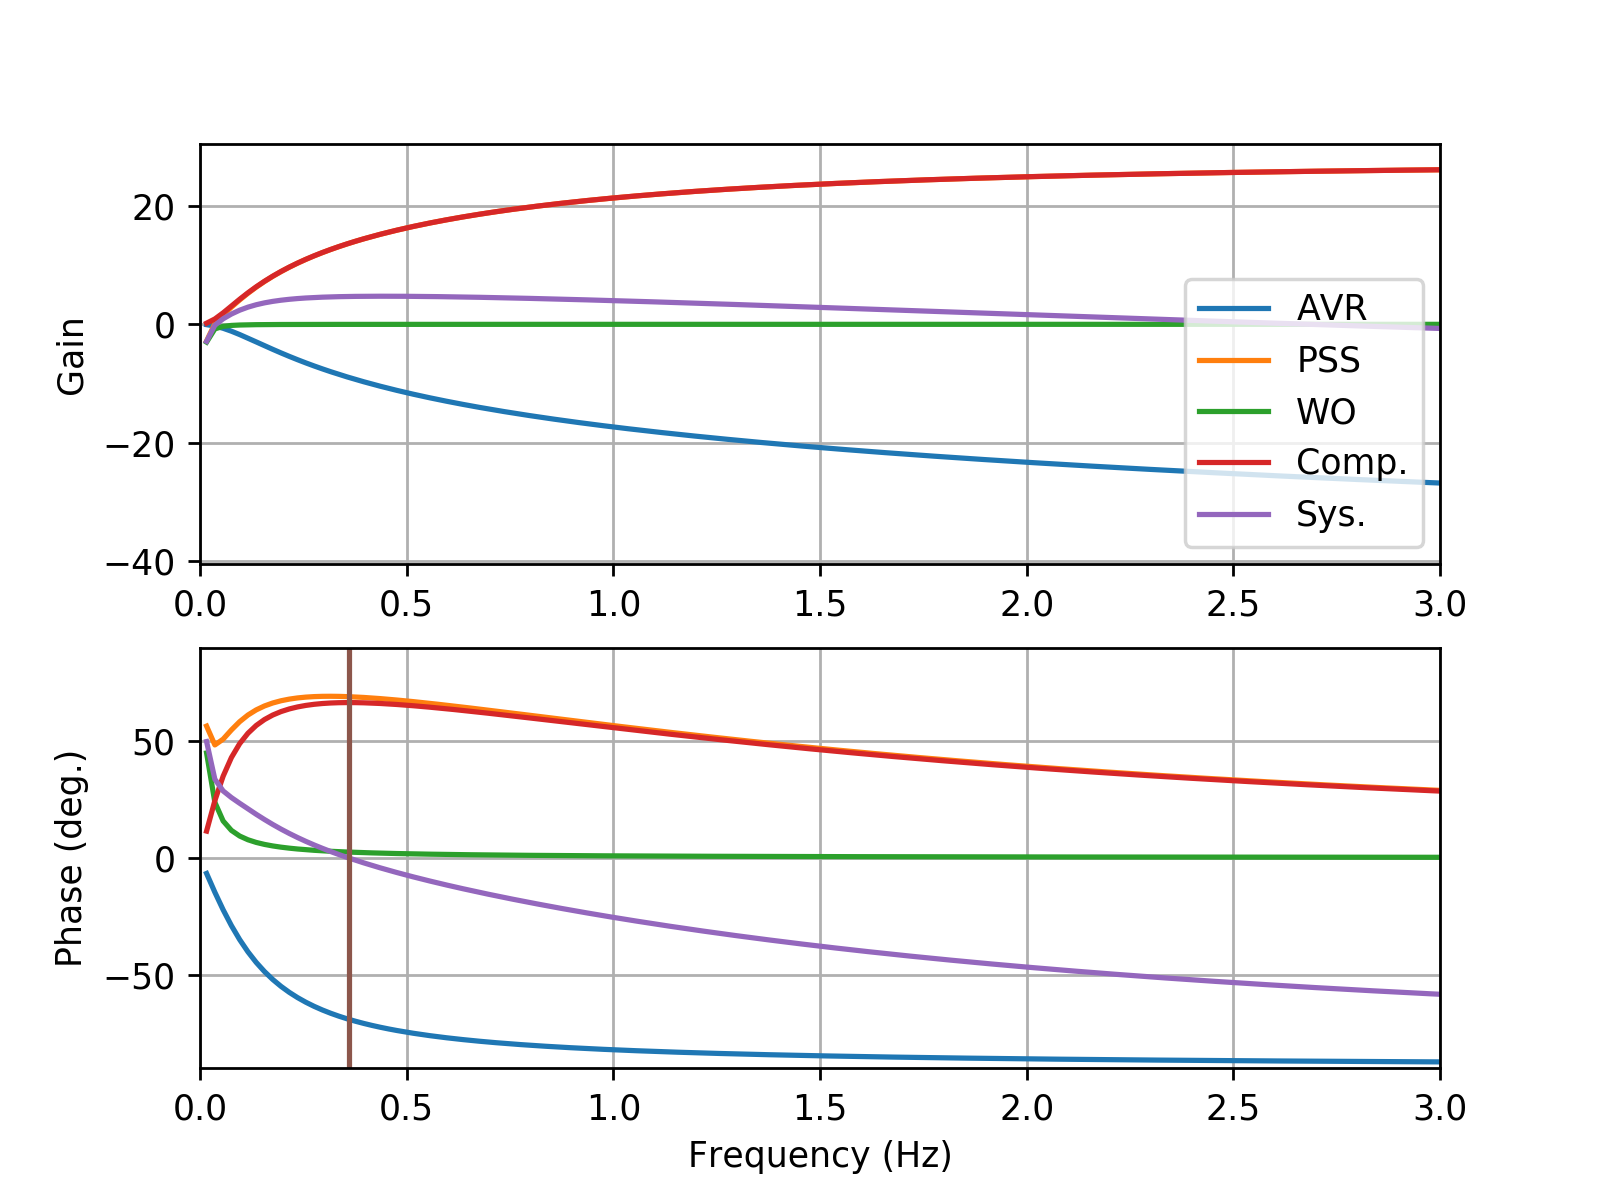

Text(0.5, 0, 'Frequency (Hz)')

In [20]:
fig, axes = plt.subplots(nrows=2)
axes[0].plot(w_avr/(2*np.pi),mag_avr, label = 'AVR')
axes[1].plot(w_avr/(2*np.pi),phase_avr)

axes[0].plot(w_pss/(2*np.pi),mag_pss, label = 'PSS')
axes[1].plot(w_pss/(2*np.pi),phase_pss)

axes[0].plot(w_wo/(2*np.pi),mag_wo, label = 'WO')
axes[1].plot(w_wo/(2*np.pi),phase_wo)

axes[0].plot(w_lead/(2*np.pi),mag_lead, label = 'Comp.')
axes[1].plot(w_lead/(2*np.pi),phase_lead)

axes[0].plot(w_sys/(2*np.pi),mag_sys, label = 'Sys.')
axes[1].plot(w_sys/(2*np.pi),phase_sys)

axes[1].plot([freq,freq],[-90,90])


axes[0].grid()
axes[1].grid()

axes[0].set_xlim(0,3)
axes[1].set_xlim(0,3)
axes[1].set_ylim(-90,90)
axes[0].legend()

axes[0].set_ylabel('Gain')
axes[1].set_ylabel('Phase (deg.)')
axes[1].set_xlabel('Frequency (Hz)')


### Para PSAT PSS type 2

In [21]:
avr_num = 1
model = 2
input_signal = 1 # omega
vs_max = 0.05
vs_min =-0.05
K_w = 10.0
T_w = T_wo
T_1_ = T_1[0]
T_2_ = T_2[0]
T_3 = 1
T_4 = 1
string = f'{avr_num}  {model}  {input_signal} '
string+= f'{vs_max}  {vs_min} {K_w} {T_w}  {T_1_:0.3f} {T_2_:0.3f}  {T_3}  {T_4} '
string+= f'25  0.5  0  0  0.045  0.045  0.045  -0.045  1  0.95  0  1;'

print(string)

1  2  1 0.05  -0.05 10.0 10.0  2.135 0.092  1  1 25  0.5  0  0  0.045  0.045  0.045  -0.045  1  0.95  0  1;


## Symbolic development for Lead-Lag

In [293]:
import sympy

a,T,w_m,sin_phi = sympy.symbols('a,T,w_m,sin_phi')

eq1 = w_m - 1/(T*sympy.sqrt(a))
eq2 = sin_phi - (a-1)/(a+1)

sol = sympy.solve([eq1,eq2],a,T)

In [22]:
T_1_

2.135356495149433

In [23]:
T_2_

0.09153029696392796